In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

git init
git add -A
git commit -m 'Added my project'
git remote add origin https://github.com/Nong-Duy-Tran/Stock-with-LSTM.git
git push -u -f origin main

## Get data from alphavantage

In [3]:
# alphavantage or kaggle
# if use kaggle have to download your own dataset
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'Your_API_Key'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)


File already exists. Loading data from CSV


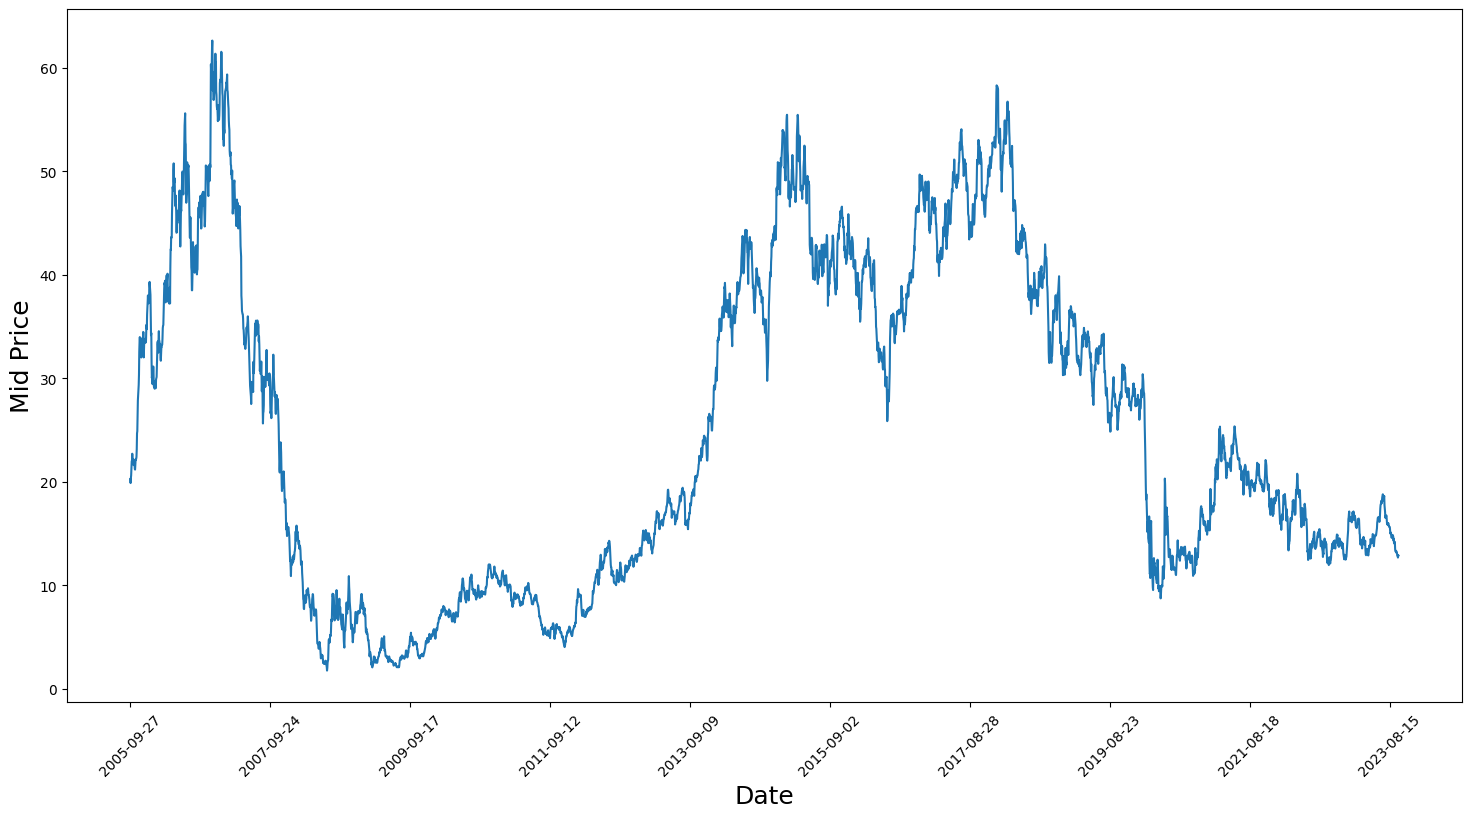

In [4]:
df = df.sort_values('Date')

plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Take the average price of the day

In [59]:
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

print(high_prices)
print(low_prices)
print(len(mid_prices))

[21.4   20.53  20.58  ... 12.83  13.09  13.065]
[19.1  19.2  20.1  ... 12.5  12.56 12.65]
4533


### Split and reshape the dataset

In [60]:
train_data = mid_prices[:2266]
test_data = mid_prices[2266:]


array([[20.25  ],
       [19.865 ],
       [20.34  ],
       ...,
       [35.76  ],
       [35.4225],
       [35.57  ]])

In [ ]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

train_data

### Normalize the data

In [61]:
# The reason why choose 730 (or 1134) base on the price graph, we can easily observe that the price of the stock being change rapidly every 2 years
# If we fit whole dataset into normalize model, most of the values after normalizing will be approximately zero

timestep = 730 #1134

for di in range(0, 730*(len(train_data)//730), timestep):
    scaler.fit(train_data[di:di+timestep,:])
    train_data[di:di+timestep,:] = scaler.transform(train_data[di:di+timestep,:])

scaler.fit(train_data[di+timestep:,:])
train_data[di+timestep:,:] = scaler.transform(train_data[di+timestep:,:])


In [62]:
train_data

array([[0.30396584],
       [0.29764348],
       [0.3054438 ],
       ...,
       [0.06075534],
       [0.02380952],
       [0.03995621]])

In [ ]:
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

test_data